In [1]:
import pandas as pd
import pandasql as ps
import pyodbc
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import categorical_accuracy
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM
from keras.layers import GlobalMaxPool1D, Conv1D, Dropout, GRU, Flatten, MaxPooling1D
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [2]:
#Grab data from a database

def getData(Server, UID, PWD, Database, query):    
    
    #create a SQL connection based on the given server and database
    sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                              'SERVER='+Server+';' 
                              'UID='+UID+';'
                              'PWD='+PWD+';'
                              'DATABASE='+Database+';' )
    
    #return the data from the given Query and SQL connection,
    return pd.read_sql(query, sql_conn)

In [51]:
#establish my server and corresponding database to pull data from
server ='GSDEMO2HOST'
database = 'MClinical'
UID = 'gsanalytics'
PWD = 'G3st@lt'


#grab all params and bucketname from bucketParams
query ="select * from MClinicalAnalytics.dbo.BucketParams"
original = getData(server, UID, PWD, database,query)
data = original.copy()


#grab all the distinct subspecialtys. replace null with unknown
query ="SELECT DISTINCT ISNULL(ProcedureStep.subSpecialtyCd, 'UNKNOWN') as subSpecialtyCd FROM ProcedureStep"
subSpecialtyCd = getData(server, UID, PWD, database, query)

#grab all the distinct locationNames. replace null with unknown
query ="SELECT DISTINCT ISNULL(PL.locationName, 'UNKNOWN') as locationName FROM FillerOrder LEFT JOIN LOCATION AS PL ON FillerOrder.scheduledLocationKey = PL.locationKey"
locationNameCd = getData(server, UID, PWD, database, query)

#grab all the distinct Status, replace null with unknown
query ="SELECT DISTINCT FillerOrder.fillerOrderStatusCd FROM FillerOrder"
fillerOrderStatusCd = getData(server, UID, PWD, database, query)

#Used to map a bucketName to a bucketNum, along with mapping to a integer from 0-4
bucketNumCd = ['1','2','3','4','5']
bucketNumCd = np.asarray(bucketNumCd)

In [52]:
#for all subspecialtys in data, map the string value of the subspecialty to its corresponding
#index value in subSpecialtyCd.
#this is used to map the subspecialty to a integer for our model to take as an input
data['subSpecialtyCd'] = data.subSpecialtyCd.apply(lambda x: np.where(subSpecialtyCd.values == x)[0][0])

#for all status in data, map the string value of the status to its corresponding
#index value in fillerOrderStatusCd.
#this is used to map the status to a integer for our model to take as an input
data['fillerOrderStatusCd'] = data.fillerOrderStatusCd.apply(lambda x: np.where(fillerOrderStatusCd.values == x)[0][0])

#for all locationName in data, map the string value of the locationName to its corresponding
#index value in locationNameCd.
#this is used to map the locationNameCd to a integer for our model to take as an input
data['locationName'] = data.locationName.apply(lambda x: np.where(locationNameCd.values == x)[0][0])

#for all bucketName in data, map the string value of the bucketName to its corresponding
#index value in bucketNumCd.
#this is used to map the bucketNumCd to a integer for our model to compare its output against
data['bucketName'] = data.bucketName.apply(lambda x: np.where(bucketNumCd == x)[0][0])

In [53]:
data

,subSpecialtyCd,locationName,fillerOrderStatusCd,bucketName
0,0,0,0,4
1,0,1,0,4
2,0,2,0,4
3,0,3,0,4
4,0,4,0,4
5,0,5,0,4
6,0,6,0,4
7,0,7,0,4
8,0,8,0,4
9,0,9,0,4


In [55]:
#create the training input set based on the three params
x = data[['subSpecialtyCd', 'fillerOrderStatusCd', 'locationName' ]]

#create the training labels set
y = data[['bucketName']]

In [56]:
x.shape

(4560, 3)

In [57]:
def create_model(max_words, maxlen):
    #keras default model
    model = Sequential()
    
    #add an embedding layer with the input dim and input length
    model.add(Embedding(input_dim = max_words, input_length=maxlen, output_dim = 50))
    
    #add a bidirectional LSTM layer with 32 units
    model.add(Bidirectional(LSTM(units =32)))
    
    # create a dense output layer with the units = len(bucketNumCd)
    model.add(Dense(5, activation='softmax'))
    
    #print the summary
    model.summary()
    
    return model

In [58]:
#create the model, 
#we define the max_words to be the sum of the lengths of 
#subSpecialtyCd, locationNameCd, and fillerOrderStatusCd

#we define the max_len to be the total number of params we pass into the model
# so in our case 3.
model = create_model(55, 3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3, 50)             2750      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                21248     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 24,323
Trainable params: 24,323
Non-trainable params: 0
_________________________________________________________________


In [59]:
#train the model
def train_model(model, x_train, y_train, epochs, batchsize, max_words, max_len):
    #compile the model
    #optimizer -> rmsprop (standard)
    #loss -> sparse categorical crossentropy (because we have a  multiclassification problem)
    #meteric -> accuracy
    model.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc']) 
    #save the history from the model
    #set the paramiters
    #fit the model
    
    history = model.fit(x_train, 
                        y_train,
                        epochs=epochs,
                        batch_size=batchsize,
                        validation_split=0)
    return history

In [60]:
#train the model 
history = train_model(model, x, y, 50, 128, 55, 3)

Epoch 1/50
4560/4560 [==============================] - 2s 478us/step - loss: 1.0129 - acc: 0.8478
Epoch 2/50
4560/4560 [==============================] - 0s 52us/step - loss: 0.4011 - acc: 0.8667
Epoch 3/50
4560/4560 [==============================] - 0s 49us/step - loss: 0.3139 - acc: 0.8741
Epoch 4/50
4560/4560 [==============================] - 0s 49us/step - loss: 0.2406 - acc: 0.8930
Epoch 5/50
4560/4560 [==============================] - 0s 57us/step - loss: 0.1714 - acc: 0.9702
Epoch 6/50
4560/4560 [==============================] - 0s 61us/step - loss: 0.1214 - acc: 0.9827
Epoch 7/50
4560/4560 [==============================] - 0s 54us/step - loss: 0.0955 - acc: 0.9829
Epoch 8/50
4560/4560 [==============================] - 0s 49us/step - loss: 0.0793 - acc: 0.9829
Epoch 9/50
4560/4560 [==============================] - 0s 48us/step - loss: 0.0657 - acc: 0.9827
Epoch 10/50
4560/4560 [==============================] - 0s 56us/step - loss: 0.0528 - acc: 0.9840
Epoch 11/50
4560/4

In [61]:
#generate the report for the training process
def training_report(history):
    #get the data from the model history file 
    acc = history.history['acc']
    loss = history.history['loss']
    
    #set our epochs
    epochs = range(1, len(acc) + 1)

    #plot the accuracy 
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.title('Trainingaccuracy')
    plt.legend()

    plt.figure()
    
    #plot the loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.title('Training loss')
    plt.legend()

    plt.show()


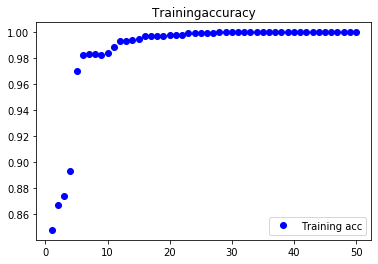

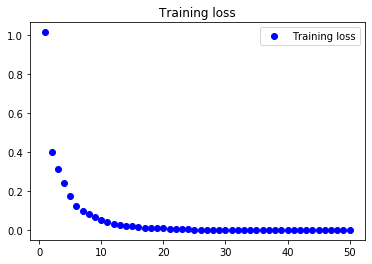

In [62]:
training_report(history)

In [63]:
#test the model on our testing data
def test_model(model, x_test):
    #gather the models prediction 
    
    #the model displays its prediction as a percent for every bucket at how confident the model is for 
    #each bucket. 
    
    #the highest percent in our case the the bucket the model has choosen
    preds = model.predict(x_test)
    
    y_pred = []
    
    #for ever row in the prediction list
    #grab the max value and append that index to the y_pred
    for row in preds:
        y_pred.append(np.argmax(row))
    
    #convert the list to a numpy array
    return np.asarray(y_pred)

In [64]:
#create the confusion matrix
def test_confusion_matrix(y_pred,y_test):
    print(confusion_matrix(y_test, y_pred))

In [65]:
#create the classification report
def test_classification_report(y_pred,y_test):
    print(classification_report(y_test, y_pred))

In [138]:
#grab all params and bucketname from bucket1Items
#this is a small test set of 10 examples that only belong to buckets 3 and 4 
query ="SELECT ISNULL(MClinical.dbo.ProcedureStep.subSpecialtyCd,'UNKNOWN') AS subSpecialtyCd, MClinical.dbo.FillerOrder.fillerOrderStatusCd, PL.locationName, MClinicalAnalytics.dbo.bucket1Items.bucketName FROM MClinicalAnalytics.dbo.bucket1Items LEFT JOIN MClinical.dbo.ProcedureStep ON MClinicalAnalytics.dbo.bucket1Items.procedureStepKey = MClinical.dbo.ProcedureStep.procedureStepKey LEFT JOIN MClinical.dbo.RequestedProcedure ON MClinical.dbo.ProcedureStep.requestedProcedureKey = MClinical.dbo.RequestedProcedure.requestedProcedureKey LEFT JOIN MClinical.dbo.FillerOrder ON MClinical.dbo.RequestedProcedure.fillerOrderKey = MClinical.dbo.FillerOrder.fillerOrderKey LEFT JOIN MClinical.dbo.LOCATION AS PL ON MClinical.dbo.FillerOrder.scheduledLocationKey = PL.locationKey"
original1 = getData(server, UID, PWD, database,query)
data1 = original1.copy()

In [139]:
#display the data before preprocessing

data1

,subSpecialtyCd,fillerOrderStatusCd,locationName,bucketName
0,*GP,F,Holy Family Hospital - Incyte,3
1,*GYP,F,InCyte Diagnostics Walla Walla,4
2,*GYP,F,InCyte Diagnostics Walla Walla,4
3,*GP,F,Kadlec Medical Center,3
4,*OP,F,InCyte Diagnostics Spokane,3
5,*GYP,F,InCyte Diagnostics Walla Walla,4
6,*GIP,F,Holy Family Hospital - Incyte,3
7,*GYP,F,InCyte Diagnostics Walla Walla,4
8,*GYP,F,InCyte Diagnostics Walla Walla,4
9,*GYP,F,InCyte Diagnostics Walla Walla,4


In [140]:
#this is where we preprocess the model
#we want to map all the params to the same integer as we trained on

#for example subspecialty *gp is at index 5 of our distinct list of all subspecialties
#during training *gp was associated with intger number 5, so we need to keep that consistent for testing.

data1['subSpecialtyCd'] = data1.subSpecialtyCd.apply(lambda x: np.where(subSpecialtyCd.values == x)[0][0])
data1['fillerOrderStatusCd'] = data1.fillerOrderStatusCd.apply(lambda x: np.where(fillerOrderStatusCd.values == x)[0][0])
data1['locationName'] = data1.locationName.apply(lambda x: np.where(locationNameCd.values == x)[0][0])
data1['bucketName'] = data1.bucketName.apply(lambda x: np.where(bucketNumCd == x)[0][0])

In [141]:
#display the "vectorized" training data
data1

,subSpecialtyCd,fillerOrderStatusCd,locationName,bucketName
0,5,3,18,2
1,7,3,16,3
2,7,3,16,3
3,5,3,12,2
4,14,3,1,2
5,7,3,16,3
6,4,3,18,2
7,7,3,16,3
8,7,3,16,3
9,7,3,16,3


In [182]:
#create the test input set based on the three params
x_test = data1[['subSpecialtyCd', 'fillerOrderStatusCd', 'locationName' ]]

#create the test labels set
y_test = data1[['bucketName']]

In [143]:
#test the model against our test data and store the predictions in Y_pred
Y_pred = test_model(model, x_test)

In [144]:
#display the confusion matrix on the predictions
test_confusion_matrix(Y_pred,y_test)

[[4 0]
 [0 6]]


In [145]:
#display the classification report on the predictions
test_classification_report(Y_pred, y_test)

              precision    recall  f1-score   support

           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         6

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [146]:
#here we convert from an integer or "vectorized" form of data 
#back to its corresponding string value

#for all subspecialty integers in data1, map the integer back to the corresponding string value
#in our distinct list called subSpecialtyCd

#for example. subspecialty 5 is the index value to *gp, so map index 5 back to *gp

data1['subSpecialtyCd'] = data1.subSpecialtyCd.apply(lambda x: subSpecialtyCd.values.item(x))
data1['fillerOrderStatusCd'] = data1.fillerOrderStatusCd.apply(lambda x: fillerOrderStatusCd.values.item(x))
data1['locationName'] = data1.locationName.apply(lambda x: locationNameCd.values.item(x))
data1['bucketName'] = data1.bucketName.apply(lambda x: bucketNumCd.item(x))

#now we want to add the predicted bucket Name to our data1 for comparison.
data1['predBucketName'] = pd.DataFrame(Y_pred)

#since we have not mapped back the index value of the bucketNum to the string value of the bucketName
#we can simpley do that by ...
#for every prediction we grab the item at the corresponding index from bucketNumCd


data1['predBucketName'] = data1.predBucketName.apply(lambda x: bucketNumCd.item(x))

In [147]:
#display the "un-vectorized" testing data along with the predicted bucket
data1

,subSpecialtyCd,fillerOrderStatusCd,locationName,bucketName,predBucketName
0,*GP,F,Holy Family Hospital - Incyte,3,3
1,*GYP,F,InCyte Diagnostics Walla Walla,4,4
2,*GYP,F,InCyte Diagnostics Walla Walla,4,4
3,*GP,F,Kadlec Medical Center,3,3
4,*OP,F,InCyte Diagnostics Spokane,3,3
5,*GYP,F,InCyte Diagnostics Walla Walla,4,4
6,*GIP,F,Holy Family Hospital - Incyte,3,3
7,*GYP,F,InCyte Diagnostics Walla Walla,4,4
8,*GYP,F,InCyte Diagnostics Walla Walla,4,4
9,*GYP,F,InCyte Diagnostics Walla Walla,4,4


In [171]:
#grab all params and bucketname from bucketItems
#this is a large test set of 10000 examples
#this will really see how our model handles
query ="SELECT ISNULL(MClinical.dbo.ProcedureStep.subSpecialtyCd,'UNKNOWN') AS subSpecialtyCd, MClinical.dbo.FillerOrder.fillerOrderStatusCd, PL.locationName, MClinicalAnalytics.dbo.bucketItems.bucketName FROM MClinicalAnalytics.dbo.bucketItems LEFT JOIN MClinical.dbo.ProcedureStep ON MClinicalAnalytics.dbo.bucketItems.procedureStepKey = MClinical.dbo.ProcedureStep.procedureStepKey LEFT JOIN MClinical.dbo.RequestedProcedure ON MClinical.dbo.ProcedureStep.requestedProcedureKey = MClinical.dbo.RequestedProcedure.requestedProcedureKey LEFT JOIN MClinical.dbo.FillerOrder ON MClinical.dbo.RequestedProcedure.fillerOrderKey = MClinical.dbo.FillerOrder.fillerOrderKey LEFT JOIN MClinical.dbo.LOCATION AS PL ON MClinical.dbo.FillerOrder.scheduledLocationKey = PL.locationKey"
original2 = getData(server, UID, PWD, database,query)
data2 = original2.copy()

In [172]:
#display the large test set
data2

,subSpecialtyCd,fillerOrderStatusCd,locationName,bucketName
0,*GYP,F,InCyte Diagnostics Bellevue,4
1,*GYP,F,InCyte Diagnostics Bellevue,4
2,*GYP,F,InCyte Diagnostics Bellevue,4
3,*DP,F,InCyte Diagnostics Bellevue,2
4,*GYP,F,InCyte Diagnostics Bellevue,4
5,*DP,F,InCyte Diagnostics Bellevue,2
6,*NS,F,InCyte Diagnostics Bellevue,2
7,*GP,F,InCyte Diagnostics Bellevue,2
8,*GYP,F,InCyte Diagnostics Bellevue,4
9,*GYP,F,InCyte Diagnostics Bellevue,4


In [173]:
#preprocess the input data labels
#same as mentioned before

data2['subSpecialtyCd'] = data2.subSpecialtyCd.apply(lambda x: np.where(subSpecialtyCd.values == x)[0][0])
data2['fillerOrderStatusCd'] = data2.fillerOrderStatusCd.apply(lambda x: np.where(fillerOrderStatusCd.values == x)[0][0])
data2['locationName'] = data2.locationName.apply(lambda x: np.where(locationNameCd.values == x)[0][0])
data2['bucketName'] = data2.bucketName.apply(lambda x: np.where(bucketNumCd == x)[0][0])

In [174]:
#display the vectorized input and labels
data2

,subSpecialtyCd,fillerOrderStatusCd,locationName,bucketName
0,7,3,15,3
1,7,3,15,3
2,7,3,15,3
3,2,3,15,1
4,7,3,15,3
5,2,3,15,1
6,13,3,15,1
7,5,3,15,1
8,7,3,15,3
9,7,3,15,3


In [175]:
#create training inputs and labels
x_test = data2[['subSpecialtyCd', 'fillerOrderStatusCd', 'locationName' ]]
y_test = data2[['bucketName']]

In [176]:
#test the model against our test data and store the predictions in y_pred
Y_pred = test_model(model, x_test)

In [177]:
#display the confusion matrix
test_confusion_matrix(Y_pred,y_test)

[[3065    0    0    0    0]
 [   0 1645    0    0    0]
 [   0    0 2731    0    0]
 [   0    0    0 1619    0]
 [   0    0    0    0  940]]


In [178]:
#display the classification report on the predictions
test_classification_report(Y_pred, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3065
           1       1.00      1.00      1.00      1645
           2       1.00      1.00      1.00      2731
           3       1.00      1.00      1.00      1619
           4       1.00      1.00      1.00       940

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [179]:
#same as before
#convert the vectorized data back to unvectorized
#add the model prediction and unvectorize

data2['subSpecialtyCd'] = data2.subSpecialtyCd.apply(lambda x: subSpecialtyCd.values.item(x))
data2['fillerOrderStatusCd'] = data2.fillerOrderStatusCd.apply(lambda x: fillerOrderStatusCd.values.item(x))
data2['locationName'] = data2.locationName.apply(lambda x: locationNameCd.values.item(x))
data2['bucketName'] = data2.bucketName.apply(lambda x: bucketNumCd.item(x))
data2['predBucketName'] = pd.DataFrame(Y_pred)
data2['predBucketName'] = data2.predBucketName.apply(lambda x: bucketNumCd.item(x))

In [183]:
#use sql against our data2 pandas dataframe to select all 
#instances where the model incorrectly predicted the bucketName
#this is the querry
q1 = """SELECT * FROM data2 where predBucketName not like bucketName"""

#use pandasql main function sqldf
#accepts two parameters.. 1 the querry, 2 the variables
#here we specify locals as our variables
#store and display the result as a pandas dataframe
pd.DataFrame(ps.sqldf(q1, locals()))


,subSpecialtyCd,fillerOrderStatusCd,locationName,bucketName,predBucketName


In [181]:
#display the results
data2

,subSpecialtyCd,fillerOrderStatusCd,locationName,bucketName,predBucketName
0,*GYP,F,InCyte Diagnostics Bellevue,4,4
1,*GYP,F,InCyte Diagnostics Bellevue,4,4
2,*GYP,F,InCyte Diagnostics Bellevue,4,4
3,*DP,F,InCyte Diagnostics Bellevue,2,2
4,*GYP,F,InCyte Diagnostics Bellevue,4,4
5,*DP,F,InCyte Diagnostics Bellevue,2,2
6,*NS,F,InCyte Diagnostics Bellevue,2,2
7,*GP,F,InCyte Diagnostics Bellevue,2,2
8,*GYP,F,InCyte Diagnostics Bellevue,4,4
9,*GYP,F,InCyte Diagnostics Bellevue,4,4
